In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor , VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,explained_variance_score

In [2]:
df = pd.read_csv("../data/processed_walmart_sales.csv")

In [3]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,12
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,19
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,26
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,5


In [4]:
df['year'].value_counts()

year
2011    2340
2010    2160
2012    1935
Name: count, dtype: int64

In [5]:
train = df[
    (df["year"] < 2012) |
    ((df["year"] == 2012) & (df["month"] <= 3))
]

# Test set: Apr–Dec 2012
test = df[
    (df["year"] == 2012) & (df["month"] > 3)
]

print("Training Data:\n", train.head(15))
print("\nTesting Data:\n", test.head())

Training Data:
     Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0       1    1643690.90             0        42.31       2.572  211.096358   
1       1    1641957.44             1        38.51       2.548  211.242170   
2       1    1611968.17             0        39.93       2.514  211.289143   
3       1    1409727.59             0        46.63       2.561  211.319643   
4       1    1554806.68             0        46.50       2.625  211.350143   
5       1    1439541.59             0        57.79       2.667  211.380643   
6       1    1472515.79             0        54.58       2.720  211.215635   
7       1    1404429.92             0        51.45       2.732  211.018042   
8       1    1594968.28             0        62.27       2.719  210.820450   
9       1    1545418.53             0        65.86       2.770  210.622857   
10      1    1466058.28             0        66.32       2.808  210.488700   
11      1    1391256.12             0        64.

In [6]:
train.shape, test.shape

((5085, 10), (1350, 10))

In [7]:
train.reset_index(drop= True, inplace=True)
test.reset_index(drop= True, inplace=True)

In [8]:
X_train = train.drop("Weekly_Sales", axis=1)
y_train = train["Weekly_Sales"]

X_test = test.drop("Weekly_Sales", axis=1)
y_test = test["Weekly_Sales"]

In [9]:
from dataclasses import dataclass, field
from typing import Optional, Dict, Any
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso

In [15]:
@dataclass
class RegressorTrainer:
    X_train: np.ndarray
    y_train: np.ndarray
    X_test: np.ndarray
    y_test: np.ndarray
    scaling: bool = True
    best_params_: Dict[str, Any] = field(default_factory=dict)
    rf_model: Optional[RandomForestRegressor] = None
    xgb_model: Optional[xgb.XGBRegressor] = None
    ridge_model: Optional[Ridge] = None
    lasso_model: Optional[Lasso] = None
    voting_model: Optional[VotingRegressor] = None
    scaler: Optional[StandardScaler] = None

    def __post_init__(self):
        # Scale X if requested
        if self.scaling:
            self.scaler = StandardScaler()
            self.X_train = self.scaler.fit_transform(self.X_train)
            self.X_test = self.scaler.transform(self.X_test)

        # Apply log transform to y
        self.y_train = np.log1p(self.y_train)  # log(1+y) to avoid issues with 0
        self.y_test = np.log1p(self.y_test)

    def train(self, tune: bool = False, n_iter: int = 20, cv: int = 3, random_state: int = 42):
        """Train RF, XGB, Ridge, Lasso, and Voting models, optionally with RandomizedSearchCV"""

        # Initialize base models
        rf = RandomForestRegressor(random_state=random_state)
        xgb_model = xgb.XGBRegressor(
            random_state=random_state,
            objective="reg:squarederror",
            n_estimators=100
        )
        ridge = Ridge(random_state=random_state)
        lasso = Lasso(random_state=random_state, max_iter=1000)

        if tune:
            print("Hyperparameter tuning enabled...")
            
            # RandomForest tuning
            rf_params = {
                "n_estimators": [100, 200, 300],
                "max_depth": [None, 5, 10, 20],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
            }
            rf_search = RandomizedSearchCV(
                rf, rf_params, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=random_state
            )
            rf_search.fit(self.X_train, self.y_train)
            rf = rf_search.best_estimator_
            self.best_params_["RandomForest"] = rf_search.best_params_

            # XGB tuning
            xgb_params = {
                "n_estimators": [100, 200, 300],
                "max_depth": [3, 5, 7, 10],
                "learning_rate": [0.01, 0.05, 0.1, 0.2],
                "subsample": [0.6, 0.8, 1.0],
                "colsample_bytree": [0.6, 0.8, 1.0],
            }
            xgb_search = RandomizedSearchCV(
                xgb_model, xgb_params, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=random_state
            )
            xgb_search.fit(self.X_train, self.y_train)
            xgb_model = xgb_search.best_estimator_
            self.best_params_["XGB"] = xgb_search.best_params_

            # Ridge tuning
            ridge_params = {
                "alpha": [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]
            }
            ridge_search = RandomizedSearchCV(
                ridge, ridge_params, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=random_state
            )
            ridge_search.fit(self.X_train, self.y_train)
            ridge = ridge_search.best_estimator_
            self.best_params_["Ridge"] = ridge_search.best_params_

            # Lasso tuning
            lasso_params = {
                "alpha": [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
            }
            lasso_search = RandomizedSearchCV(
                lasso, lasso_params, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=random_state
            )
            lasso_search.fit(self.X_train, self.y_train)
            lasso = lasso_search.best_estimator_
            self.best_params_["Lasso"] = lasso_search.best_params_
            
            print("Hyperparameter tuning completed!")
        else:
            # Fit models with default parameters
            rf.fit(self.X_train, self.y_train)
            xgb_model.fit(self.X_train, self.y_train)
            ridge.fit(self.X_train, self.y_train)
            lasso.fit(self.X_train, self.y_train)

        # Store trained models
        self.rf_model = rf
        self.xgb_model = xgb_model
        self.ridge_model = ridge
        self.lasso_model = lasso
        
        # Create voting regressor with all models
        self.voting_model = VotingRegressor([
            ("rf", rf), 
            ("xgb", xgb_model),
            ("ridge", ridge),
            ("lasso", lasso)
        ])
        self.voting_model.fit(self.X_train, self.y_train)
        
        print("All models trained successfully!")

    def evaluate(self):
        """Evaluate all models and print metrics (on original scale)"""
        models = {
            "RandomForest": self.rf_model,
            "XGBRegressor": self.xgb_model,
            "Ridge": self.ridge_model,
            "Lasso": self.lasso_model,
            "VotingRegressor": self.voting_model,
        }
        
        results = {}
        print("\nModel Performance (on original scale):")
        print("-" * 50)
        
        for name, model in models.items():
            if model is not None:
                preds_log = model.predict(self.X_test)
                preds = np.expm1(preds_log)   # inverse transform
                y_true = np.expm1(self.y_test)
                
                mse = mean_squared_error(y_true, preds)
                r2 = r2_score(y_true, preds)
                rmse = np.sqrt(mse)
                
                results[name] = {"MSE": mse, "R2": r2, "RMSE": rmse}
                print(f"{name:15} → MSE: {mse:8.4f}, R2: {r2:6.4f}, RMSE: {rmse:8.4f}")
        
        return results

    def plot_importance(self, feature_names: Optional[list] = None):
        """Plot feature importance for RandomForest, XGBoost, Ridge, and Lasso"""

        if feature_names is None:
            feature_names = [f"f{i}" for i in range(self.X_train.shape[1])]

        # Create subplots for different importance types
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle("Feature Importance Comparison", fontsize=16)

        # RandomForest feature importance
        if self.rf_model:
            importances = self.rf_model.feature_importances_
            indices = np.argsort(importances)[::-1]
            axes[0, 0].bar(range(len(importances)), importances[indices])
            axes[0, 0].set_xticks(range(len(importances)))
            axes[0, 0].set_xticklabels([feature_names[i] for i in indices], rotation=45)
            axes[0, 0].set_title("RandomForest Feature Importance")
            axes[0, 0].set_ylabel("Importance")

        # XGBoost feature importance (using gain)
        if self.xgb_model:
            importances = self.xgb_model.feature_importances_
            indices = np.argsort(importances)[::-1]
            axes[0, 1].bar(range(len(importances)), importances[indices])
            axes[0, 1].set_xticks(range(len(importances)))
            axes[0, 1].set_xticklabels([feature_names[i] for i in indices], rotation=45)
            axes[0, 1].set_title("XGBoost Feature Importance")
            axes[0, 1].set_ylabel("Importance")

        # Ridge coefficients (absolute values)
        if self.ridge_model:
            coefs = np.abs(self.ridge_model.coef_)
            indices = np.argsort(coefs)[::-1]
            axes[1, 0].bar(range(len(coefs)), coefs[indices])
            axes[1, 0].set_xticks(range(len(coefs)))
            axes[1, 0].set_xticklabels([feature_names[i] for i in indices], rotation=45)
            axes[1, 0].set_title("Ridge Regression Coefficients (Absolute)")
            axes[1, 0].set_ylabel("Absolute Coefficient Value")

        # Lasso coefficients (absolute values)
        if self.lasso_model:
            coefs = np.abs(self.lasso_model.coef_)
            indices = np.argsort(coefs)[::-1]
            axes[1, 1].bar(range(len(coefs)), coefs[indices])
            axes[1, 1].set_xticks(range(len(coefs)))
            axes[1, 1].set_xticklabels([feature_names[i] for i in indices], rotation=45)
            axes[1, 1].set_title("Lasso Regression Coefficients (Absolute)")
            axes[1, 1].set_ylabel("Absolute Coefficient Value")

        plt.tight_layout()
        plt.show()

    def plot_predictions_vs_actual(self):
        """Plot predictions vs actual values for all models"""
        models = {
            "RandomForest": self.rf_model,
            "XGBRegressor": self.xgb_model,
            "Ridge": self.ridge_model,
            "Lasso": self.lasso_model,
            "VotingRegressor": self.voting_model,
        }
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        y_true = np.expm1(self.y_test)  # Convert back to original scale
        
        for i, (name, model) in enumerate(models.items()):
            if model is not None and i < len(axes):
                preds_log = model.predict(self.X_test)
                preds = np.expm1(preds_log)  # Convert back to original scale
                
                axes[i].scatter(y_true, preds, alpha=0.6)
                axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
                axes[i].set_xlabel('Actual Values')
                axes[i].set_ylabel('Predicted Values')
                axes[i].set_title(f'{name} - Predictions vs Actual')
                
                # Add R² score to the plot
                r2 = r2_score(y_true, preds)
                axes[i].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[i].transAxes, 
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Hide empty subplot
        if len(models) < len(axes):
            axes[-1].set_visible(False)
        
        plt.tight_layout()
        plt.show()

    def get_regularization_analysis(self):
        """Analyze Ridge and Lasso regularization effects"""
        if self.ridge_model is None or self.lasso_model is None:
            print("Ridge and Lasso models must be trained first!")
            return
        
        print("\nRegularization Analysis:")
        print("-" * 40)
        
        # Ridge analysis
        ridge_alpha = self.ridge_model.alpha
        ridge_coefs = self.ridge_model.coef_
        ridge_nonzero = np.sum(np.abs(ridge_coefs) > 1e-6)
        
        print(f"Ridge Regression (α = {ridge_alpha}):")
        print(f"  - Number of non-zero coefficients: {ridge_nonzero}/{len(ridge_coefs)}")
        print(f"  - Max coefficient magnitude: {np.max(np.abs(ridge_coefs)):.6f}")
        print(f"  - Sum of squared coefficients: {np.sum(ridge_coefs**2):.6f}")
        
        # Lasso analysis
        lasso_alpha = self.lasso_model.alpha
        lasso_coefs = self.lasso_model.coef_
        lasso_nonzero = np.sum(np.abs(lasso_coefs) > 1e-6)
        
        print(f"\nLasso Regression (α = {lasso_alpha}):")
        print(f"  - Number of non-zero coefficients: {lasso_nonzero}/{len(lasso_coefs)}")
        print(f"  - Max coefficient magnitude: {np.max(np.abs(lasso_coefs)):.6f}")
        print(f"  - Sum of absolute coefficients: {np.sum(np.abs(lasso_coefs)):.6f}")
        
        # Feature selection effect of Lasso
        selected_features = np.where(np.abs(lasso_coefs) > 1e-6)[0]
        print(f"  - Features selected by Lasso: {len(selected_features)} out of {len(lasso_coefs)}")
        
        return {
            "ridge": {"alpha": ridge_alpha, "nonzero_coefs": ridge_nonzero, "coefs": ridge_coefs},
            "lasso": {"alpha": lasso_alpha, "nonzero_coefs": lasso_nonzero, "coefs": lasso_coefs, "selected_features": selected_features}
        }

    def plot_regularization_path(self, feature_names: Optional[list] = None, alphas: Optional[np.ndarray] = None):
        """Plot regularization path for Ridge and Lasso"""
        if feature_names is None:
            feature_names = [f"f{i}" for i in range(self.X_train.shape[1])]
        
        if alphas is None:
            alphas = np.logspace(-4, 2, 50)  # From 0.0001 to 100
        
        # Store coefficients for different alpha values
        ridge_coefs = []
        lasso_coefs = []
        
        print("Computing regularization paths...")
        
        for alpha in alphas:
            # Ridge path
            ridge_temp = Ridge(alpha=alpha, random_state=42)
            ridge_temp.fit(self.X_train, self.y_train)
            ridge_coefs.append(ridge_temp.coef_)
            
            # Lasso path
            lasso_temp = Lasso(alpha=alpha, random_state=42, max_iter=1000)
            lasso_temp.fit(self.X_train, self.y_train)
            lasso_coefs.append(lasso_temp.coef_)
        
        ridge_coefs = np.array(ridge_coefs)
        lasso_coefs = np.array(lasso_coefs)
        
        # Plot regularization paths
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Ridge regularization path
        for i in range(ridge_coefs.shape[1]):
            ax1.plot(alphas, ridge_coefs[:, i], label=feature_names[i])
        ax1.set_xscale('log')
        ax1.set_xlabel('Alpha (Regularization strength)')
        ax1.set_ylabel('Coefficient value')
        ax1.set_title('Ridge Regularization Path')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # Lasso regularization path
        for i in range(lasso_coefs.shape[1]):
            ax2.plot(alphas, lasso_coefs[:, i], label=feature_names[i])
        ax2.set_xscale('log')
        ax2.set_xlabel('Alpha (Regularization strength)')
        ax2.set_ylabel('Coefficient value')
        ax2.set_title('Lasso Regularization Path')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def compare_coefficients(self, feature_names: Optional[list] = None):
        """Compare coefficients across Ridge and Lasso models"""
        if self.ridge_model is None or self.lasso_model is None:
            print("Ridge and Lasso models must be trained first!")
            return
        
        if feature_names is None:
            feature_names = [f"f{i}" for i in range(self.X_train.shape[1])]
        
        ridge_coefs = self.ridge_model.coef_
        lasso_coefs = self.lasso_model.coef_
        
        # Create comparison plot
        x = np.arange(len(feature_names))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        bars1 = ax.bar(x - width/2, ridge_coefs, width, label='Ridge', alpha=0.8)
        bars2 = ax.bar(x + width/2, lasso_coefs, width, label='Lasso', alpha=0.8)
        
        ax.set_xlabel('Features')
        ax.set_ylabel('Coefficient Value')
        ax.set_title('Ridge vs Lasso Coefficients Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(feature_names, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print coefficient comparison table
        print("\nCoefficient Comparison:")
        print("-" * 60)
        print(f"{'Feature':<15} {'Ridge':<12} {'Lasso':<12} {'Difference':<12}")
        print("-" * 60)
        for i, feature in enumerate(feature_names):
            diff = abs(ridge_coefs[i] - lasso_coefs[i])
            print(f"{feature:<15} {ridge_coefs[i]:8.6f}    {lasso_coefs[i]:8.6f}    {diff:8.6f}")

    def print_best_params(self):
        """Print the best hyperparameters found during tuning"""
        if not self.best_params_:
            print("No hyperparameter tuning was performed!")
            return
        
        print("\nBest Hyperparameters:")
        print("-" * 40)
        for model_name, params in self.best_params_.items():
            print(f"{model_name}:")
            for param, value in params.items():
                print(f"  {param}: {value}")
            print()

    
    
    
    
    
    
    
    

In [16]:
# Create and train the regressor trainer
trainer = RegressorTrainer(X_train, y_train, X_test, y_test)

# Train models with hyperparameter tuning
trainer.train(tune=True, n_iter=10)

Hyperparameter tuning enabled...


c:\Users\DELL\personal-project\walmart-sales-project\walmart-env\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\DELL\personal-project\walmart-sales-project\walmart-env\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Hyperparameter tuning completed!
All models trained successfully!


In [17]:
# Evaluate models
results = trainer.evaluate()

# Print best parameters
trainer.print_best_params()



Model Performance (on original scale):
--------------------------------------------------
RandomForest    → MSE: 122548377350.5330, R2: 0.5767, RMSE: 350069.1037
XGBRegressor    → MSE: 155553189473.3130, R2: 0.4627, RMSE: 394402.3193
Ridge           → MSE: 281561289205.4693, R2: 0.0275, RMSE: 530623.4910
Lasso           → MSE: 272650848917.5180, R2: 0.0583, RMSE: 522159.7925
VotingRegressor → MSE: 178961163810.1501, R2: 0.3819, RMSE: 423038.0170

Best Hyperparameters:
----------------------------------------
RandomForest:
  n_estimators: 100
  min_samples_split: 5
  min_samples_leaf: 1
  max_depth: 5

XGB:
  subsample: 0.8
  n_estimators: 100
  max_depth: 5
  learning_rate: 0.01
  colsample_bytree: 0.8

Ridge:
  alpha: 1000.0

Lasso:
  alpha: 0.01



In [18]:
# Analyze regularization effects
trainer.get_regularization_analysis()



Regularization Analysis:
----------------------------------------
Ridge Regression (α = 1000.0):
  - Number of non-zero coefficients: 9/9
  - Max coefficient magnitude: 0.153290
  - Sum of squared coefficients: 0.032856

Lasso Regression (α = 0.01):
  - Number of non-zero coefficients: 7/9
  - Max coefficient magnitude: 0.176448
  - Sum of absolute coefficients: 0.349598
  - Features selected by Lasso: 7 out of 9


{'ridge': {'alpha': 1000.0,
  'nonzero_coefs': np.int64(9),
  'coefs': array([-0.15328991,  0.00651208, -0.04879484,  0.03042188, -0.05751102,
         -0.02636309, -0.02497102,  0.03594661, -0.00956605])},
 'lasso': {'alpha': 0.01,
  'nonzero_coefs': np.int64(7),
  'coefs': array([-1.76448332e-01,  0.00000000e+00, -4.53984725e-02,  6.62064055e-03,
         -6.65535323e-02, -1.51157546e-02, -0.00000000e+00,  3.94191547e-02,
         -4.17467758e-05]),
  'selected_features': array([0, 2, 3, 4, 5, 7, 8])}}

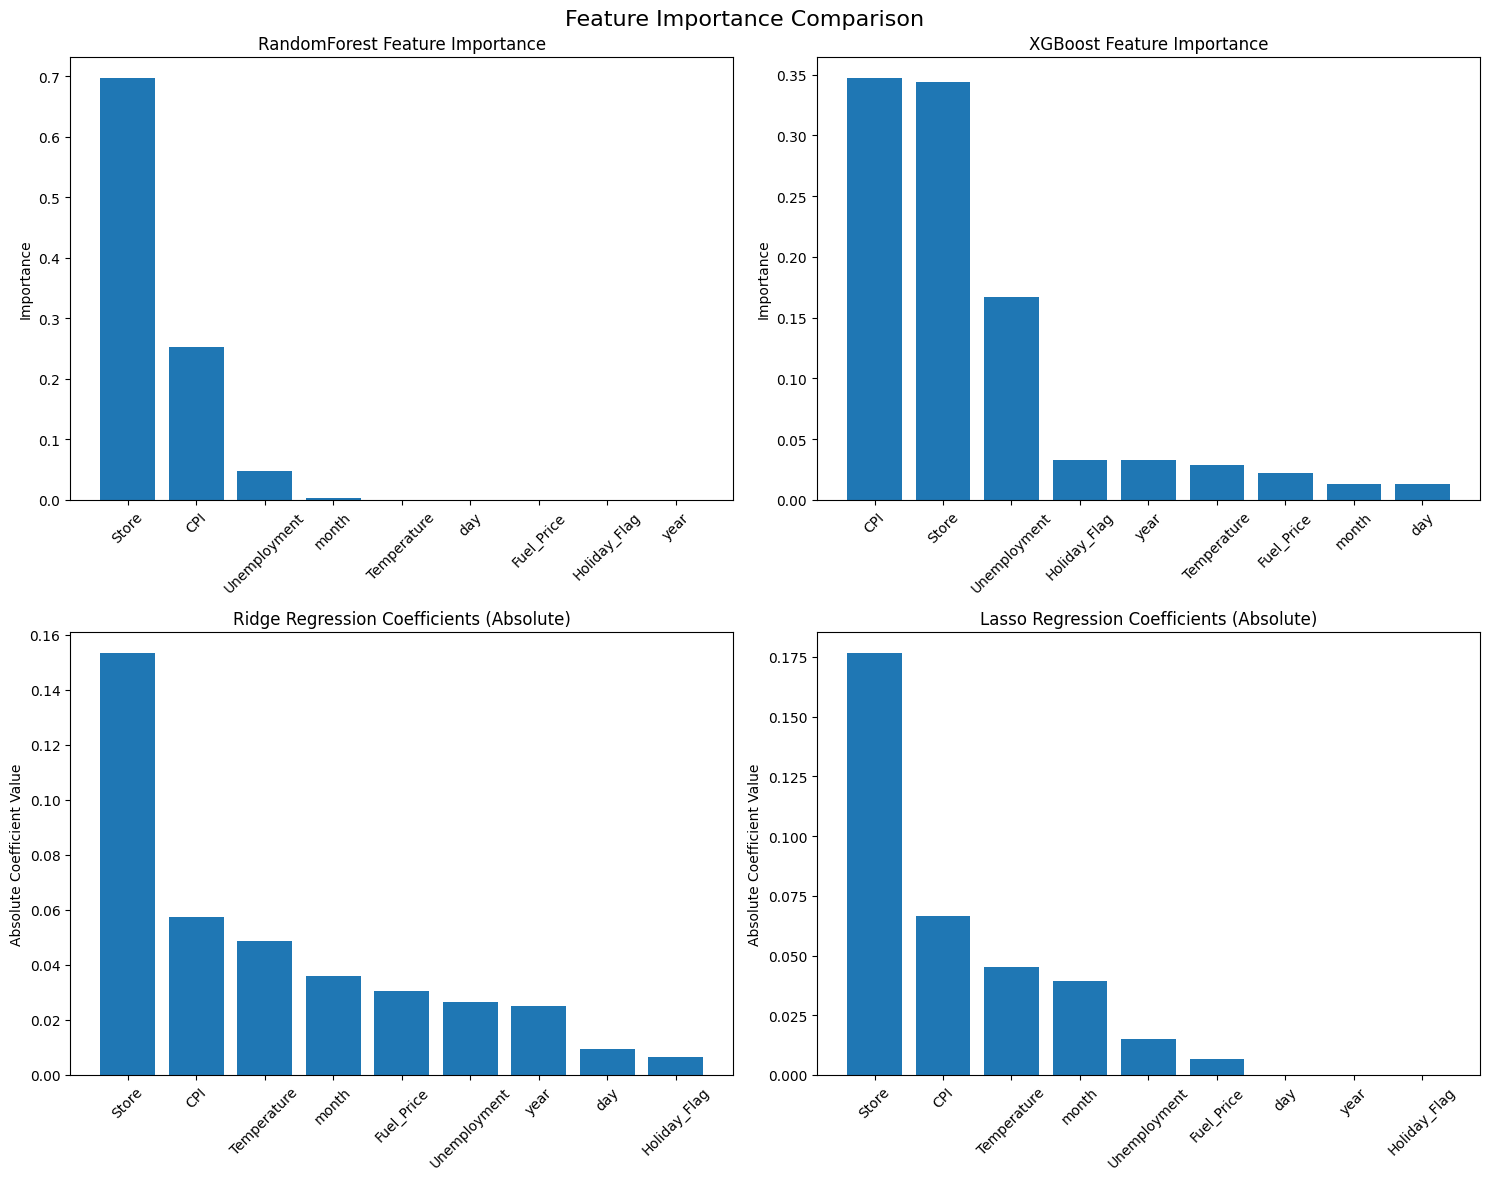

In [23]:
# Plot feature importance
trainer.plot_importance(X_train.columns.tolist())


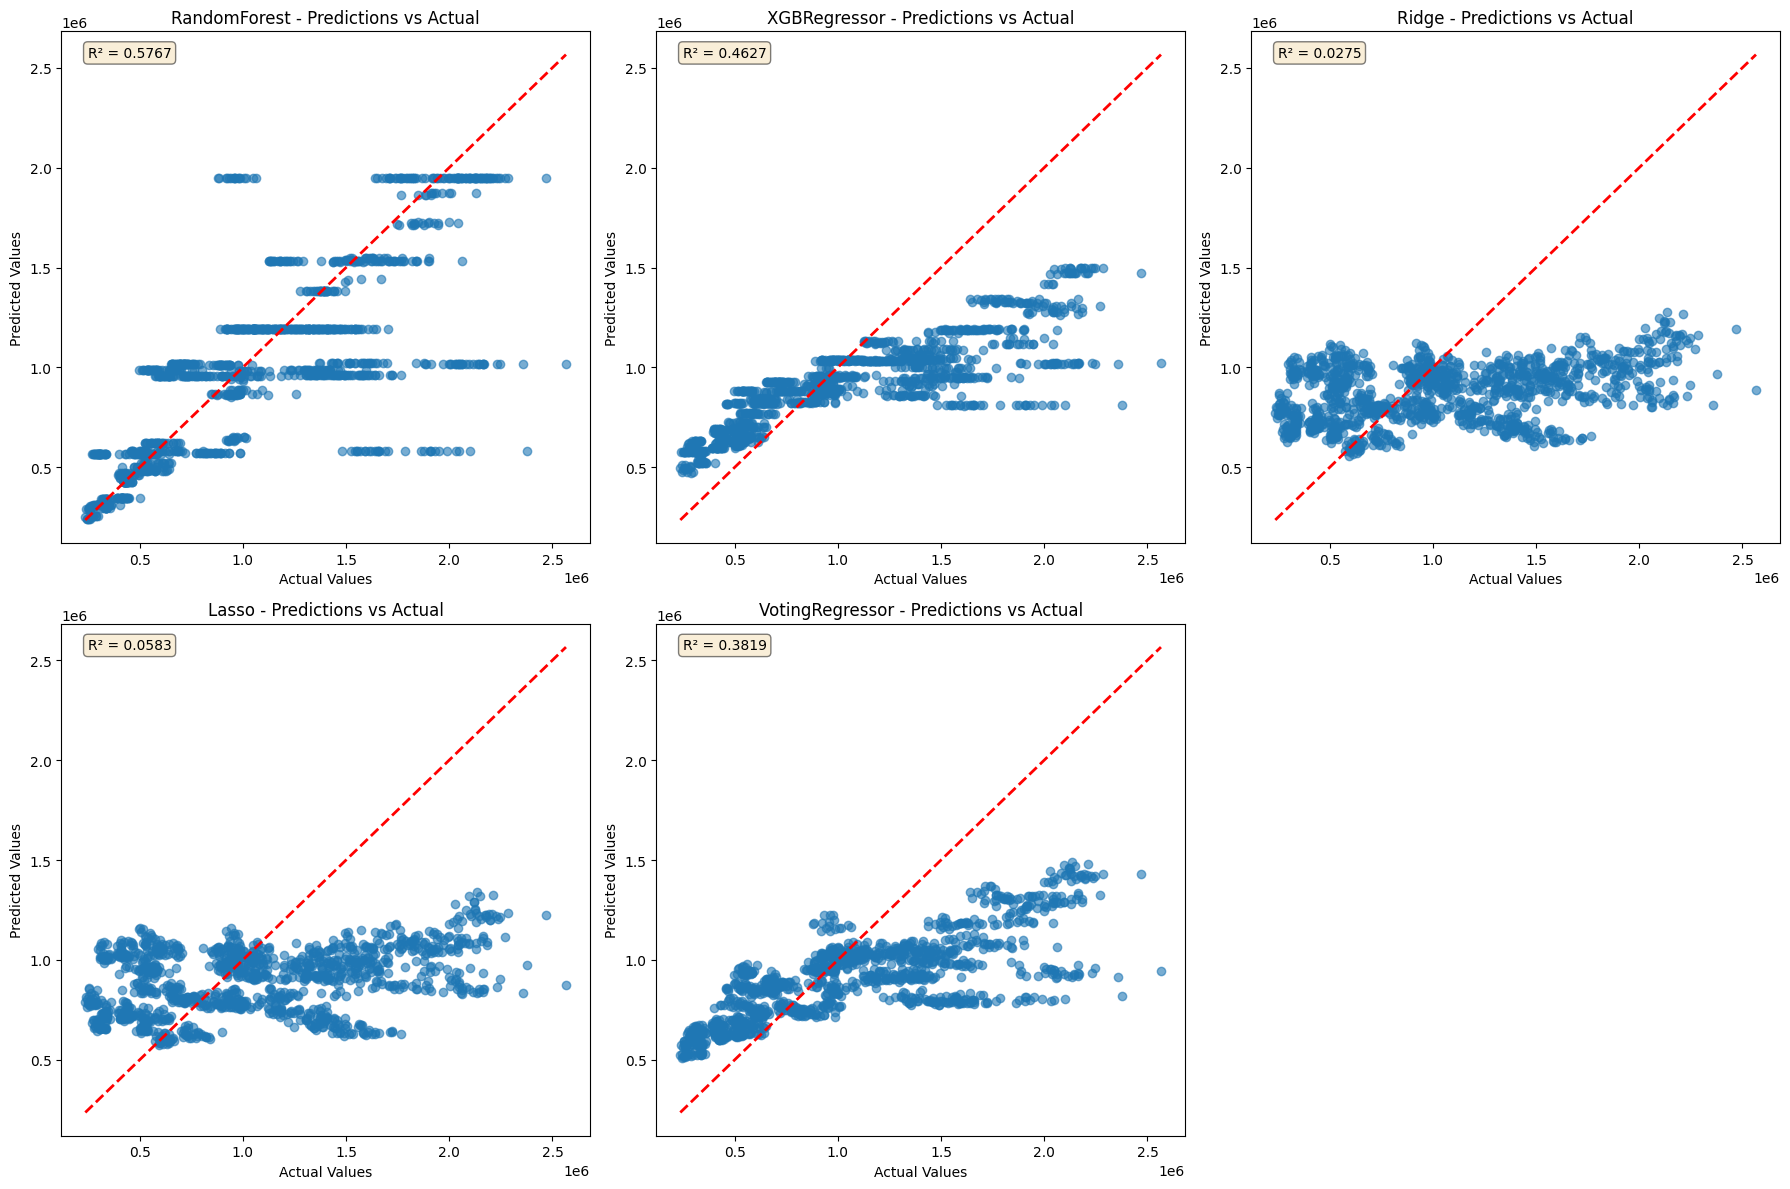

In [20]:
# Plot predictions vs actual
trainer.plot_predictions_vs_actual()


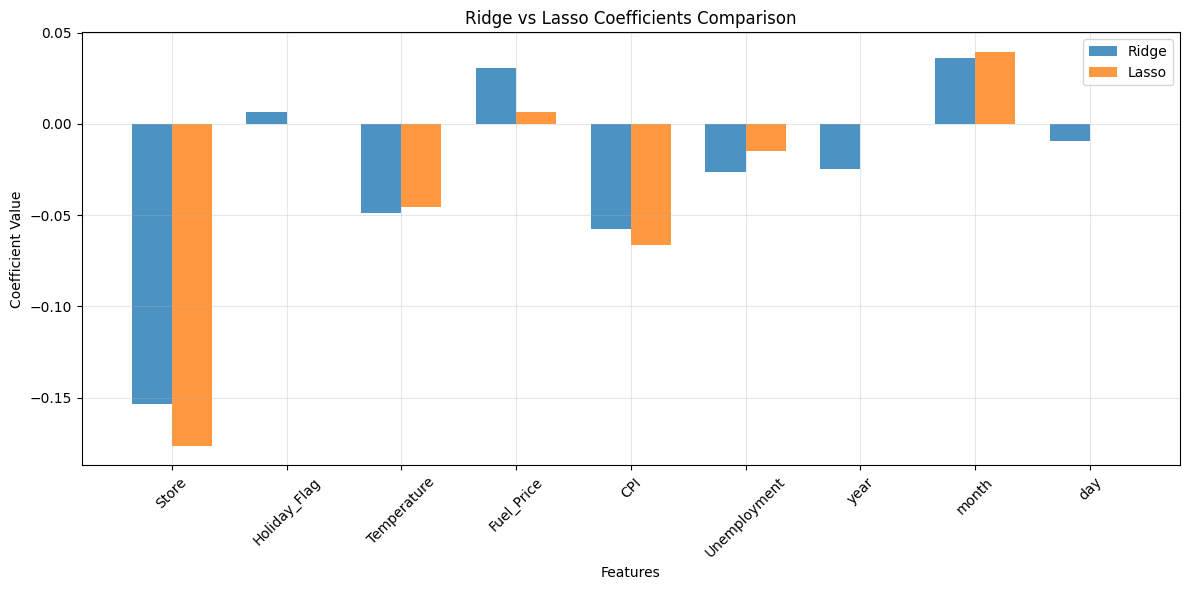


Coefficient Comparison:
------------------------------------------------------------
Feature         Ridge        Lasso        Difference  
------------------------------------------------------------
Store           -0.153290    -0.176448    0.023158
Holiday_Flag    0.006512    0.000000    0.006512
Temperature     -0.048795    -0.045398    0.003396
Fuel_Price      0.030422    0.006621    0.023801
CPI             -0.057511    -0.066554    0.009043
Unemployment    -0.026363    -0.015116    0.011247
year            -0.024971    -0.000000    0.024971
month           0.035947    0.039419    0.003473
day             -0.009566    -0.000042    0.009524


In [24]:
# Compare coefficients
trainer.compare_coefficients(X_train.columns.tolist())

Computing regularization paths...


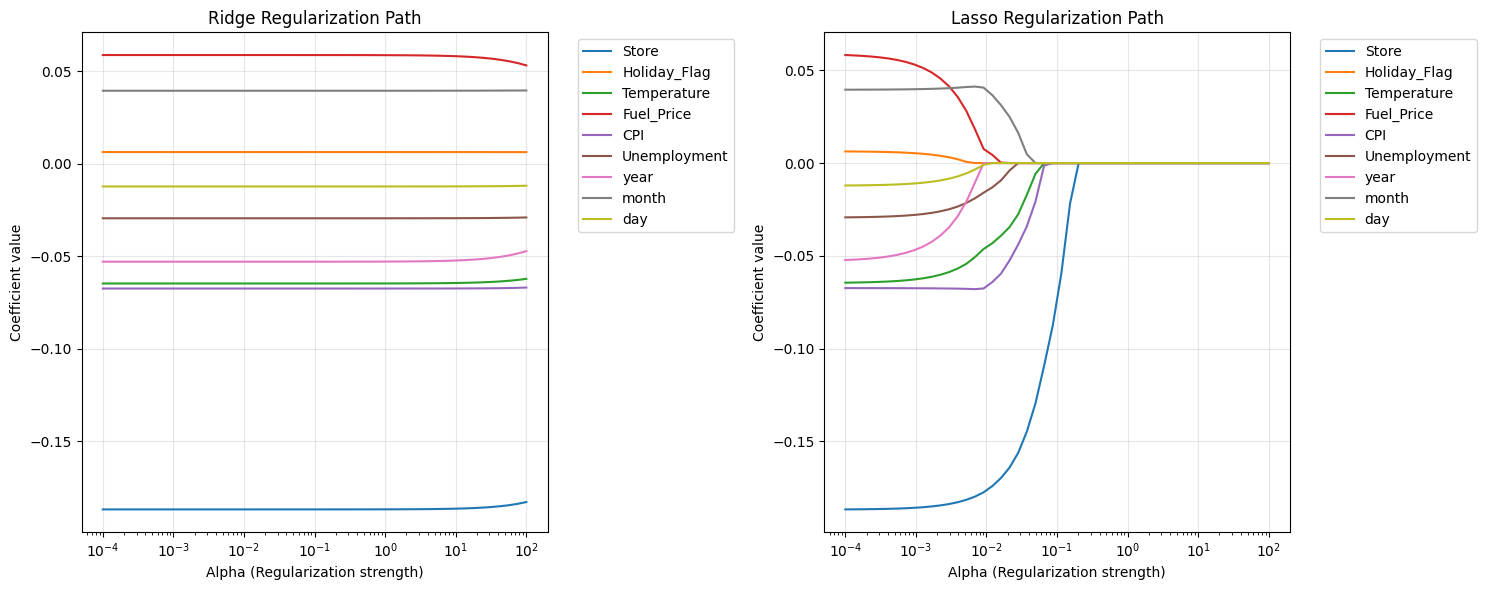

In [25]:
# Plot regularization paths
trainer.plot_regularization_path(X_train.columns.tolist())